# EDS 296 - Homework 2 - Geospatial Analysis
Josephine Cardelle

Github Repository: https://github.com/jocardelle/eds296-HW2

In [46]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Choose two models and their historical and future projections

I am chosing to use CESM2 and CanESM5. CESM2 is the community earth system model version 2, developed by the National Center for Atmospheric Research. It has representations of land, atmosphere, ocean, and ice processes. CanESM5 is the Canadian Earth System Model version 5, developed by Environment and Climate Change Canada. It is used in canada and internationally. For the future climate scenario I am using SSP370, a high emissions scenario.

In [47]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')


# member_id: which ensemble member do you want?
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon'

# variable_id: which climate variables do you want? Here we want surface air temperature
variable_id = ['tas']


In [48]:
# Historical CESM
cesm_hist = catalog.search(
    activity_id='CMIP',
    source_id='CESM2',
    experiment_id='historical',
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id)

# SSP370 Can
cesm_fut = catalog.search(
    activity_id='ScenarioMIP',
    source_id='CESM2',
    experiment_id='ssp370',
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)

# Historical
can_hist = catalog.search(
    activity_id='CMIP',
    source_id='CanESM5',
    experiment_id='historical',
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)


# SSP370
can_fut = catalog.search(
    activity_id='ScenarioMIP',
    source_id='CanESM5',
    experiment_id='ssp370',
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)


hist_cesm = xr.open_zarr(cesm_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_cesm = xr.open_zarr(cesm_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
hist_can = xr.open_zarr(can_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_can = xr.open_zarr(can_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)

hist_cesm['time'] = hist_cesm.time.astype('datetime64[ns]')
future_cesm['time'] = future_cesm.time.astype('datetime64[ns]')
hist_can['time'] = hist_can.time.astype('datetime64[ns]')
future_can['time'] = future_can.time.astype('datetime64[ns]')

# Concatenate
cesm_data = xr.concat([hist_cesm, future_cesm], dim="time")
can_data = xr.concat([hist_can, future_can], dim="time")


### Choose a region and time period of interest

I am choosing Canada as my region of interest. Climate in Canada has a large range with the north being an Arctic region and the south being more temperate. However, much of Canada experiences long and cold winters. Canada is greatly affected by climate change. The Arctic region has experienced and will continue to experience extreme warming, with glacial melting and a change in the ecology. The southern region has also seen more heatwaves and with large forested areas could be greatly affected by wildfires in the future.

For time periods I'm using 1975-2025 and 2026-2075. I chose these because I want to visualize a time period already passed and a future projection. I want to see the difference between what has happened and what we expect to happen.

In [49]:

# Define min/max bounds for region of interest 
region = [220, 308, 40, 84]

# Time period of interest
per_early = [1975, 2025]
per_late = [2026, 2075]

# Early period subset and average - cesm
early_cesm = cesm_data.sel(time=slice(f"{per_early[0]}-01-01", f"{per_early[1]}-12-31"))
early_cesm = early.sel(lat=slice(region[2], region[3]), lon=slice(region[0], region[1]))
# Kelvin to celsius
early_mean_cesm = early['tas'].mean(dim='time') - 273.15

# Late period subset and average - cesm
late_cesm = cesm_data.sel(time=slice(f"{per_late[0]}-01-01", f"{per_late[1]}-12-31"))
late_cesm = late.sel(lat=slice(region[2], region[3]), lon=slice(region[0], region[1]))
# Kelvin to Celsius
late_mean_cesm = late['tas'].mean(dim='time') - 273.15

# Early period subset and average - can
early_can = can_data.sel(time=slice(f"{per_early[0]}-01-01", f"{per_early[1]}-12-31"))
early_can = early_can.sel(lat=slice(region[2], region[3]), lon=slice(region[0], region[1]))
# Kelvin to celsius
early_mean_can = early_can['tas'].mean(dim='time') - 273.15

# Late period subset and average - can
late_can = can_data.sel(time=slice(f"{per_late[0]}-01-01", f"{per_late[1]}-12-31"))
late_can = late_can.sel(lat=slice(region[2], region[3]), lon=slice(region[0], region[1]))
# Kelvin to Celsius
late_mean_can = late_can['tas'].mean(dim='time') - 273.15

## Maps of average over each time period

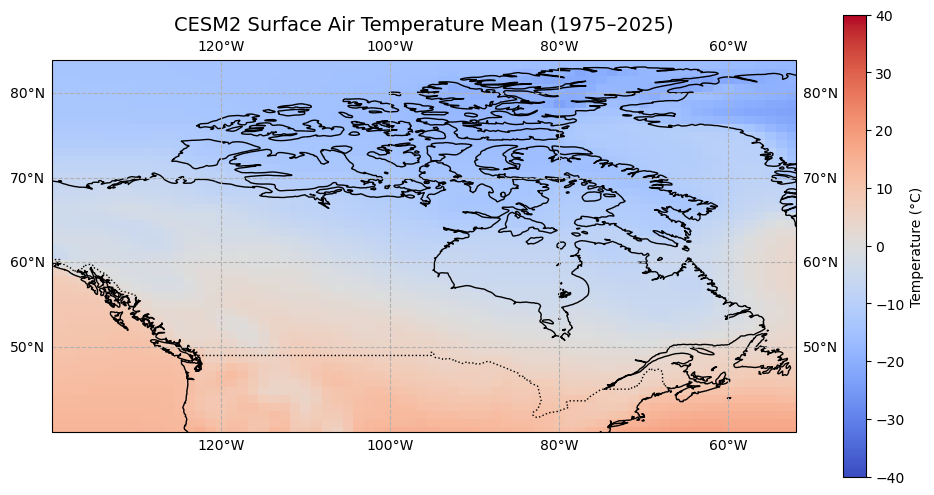

In [50]:
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(early_mean_cesm.lon, early_mean_cesm.lat, early_mean_cesm, transform=proj, cmap="coolwarm", vmin=-40, vmax=40)
ax.set_extent(region, crs=proj)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
ax.set_title("CESM2 Surface Air Temperature Mean (1975–2025)", fontsize=14)
plt.show()

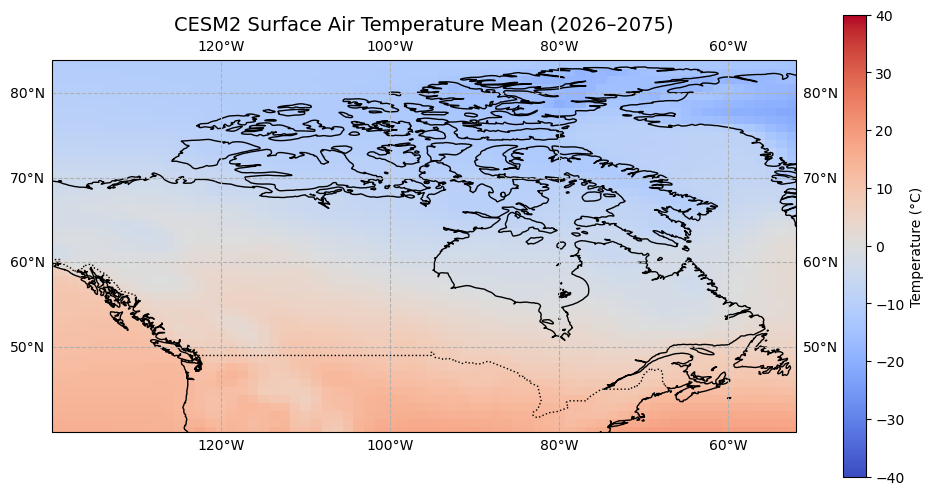

In [51]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(late_mean_cesm.lon, late_mean_cesm.lat, late_mean_cesm, transform=proj, cmap="coolwarm", vmin=-40, vmax=40)
ax.set_extent(region, crs=proj)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
ax.set_title("CESM2 Surface Air Temperature Mean (2026–2075)", fontsize=14)
plt.show()

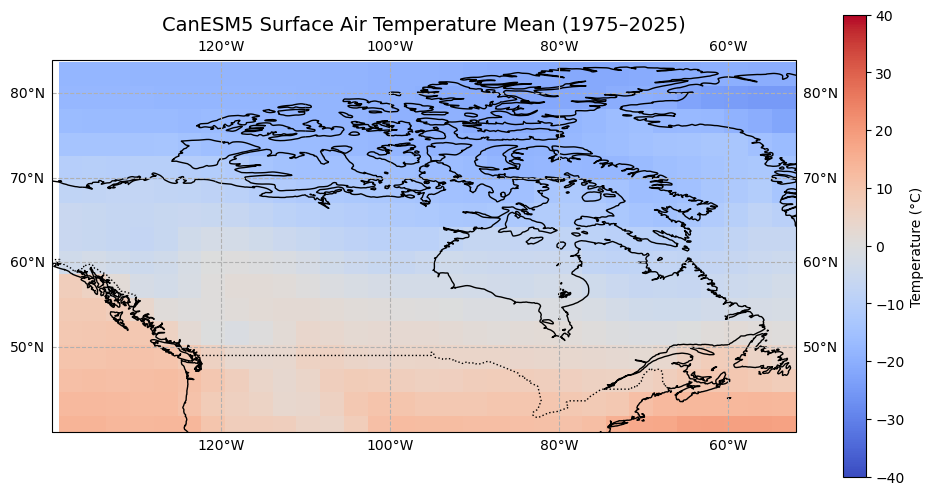

In [52]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(early_mean_can.lon, early_mean_can.lat, early_mean_can, transform=proj, cmap="coolwarm", vmin=-40, vmax=40)
ax.set_extent(region, crs=proj)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
ax.set_title("CanESM5 Surface Air Temperature Mean (1975–2025)", fontsize=14)
plt.show()

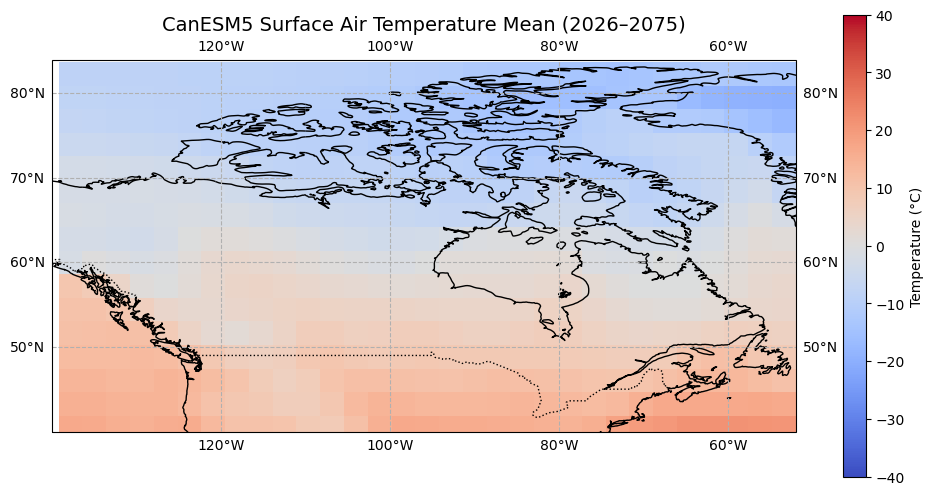

In [53]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(late_mean_can.lon, late_mean_can.lat, late_mean_can, transform=proj, cmap="coolwarm", vmin=-40, vmax=40)
ax.set_extent(region, crs=proj)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
ax.set_title("CanESM5 Surface Air Temperature Mean (2026–2075)", fontsize=14)
plt.show()

## Difference Maps

In [54]:
# Calculate differences
diff_cesm = late_mean_cesm - early_mean_cesm
diff_can = late_mean_can - early_mean_can

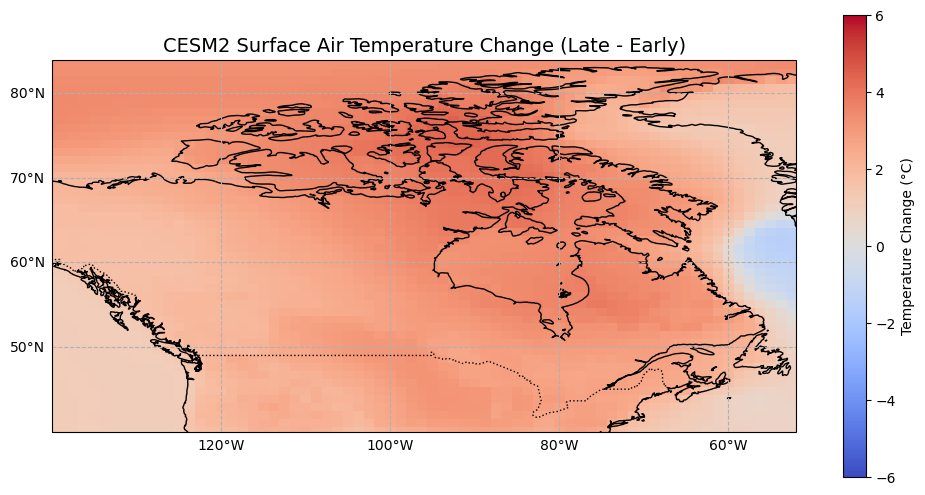

In [55]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(diff_cesm.lon, diff_cesm.lat, diff_cesm, transform=proj, cmap="coolwarm", vmin=-6, vmax=6)
ax.set_extent(region, crs=ccrs.PlateCarree())
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature Change (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
gl.top_labels = False
gl.right_labels = False
ax.set_title("CESM2 Surface Air Temperature Change (Late - Early)", fontsize=14)
plt.show()

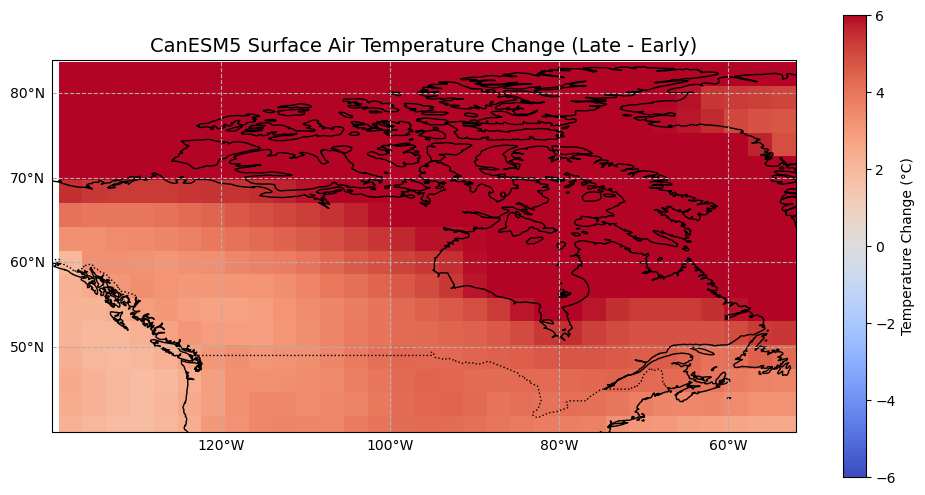

In [56]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
plot = ax.pcolormesh(diff_can.lon, diff_can.lat, diff_can, transform=proj, cmap="coolwarm", vmin=-6, vmax=6)
ax.set_extent(region, crs=ccrs.PlateCarree())
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature Change (°C)")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
gl = ax.gridlines(draw_labels=True, linestyle="--")
gl.top_labels = False
gl.right_labels = False
ax.set_title("CanESM5 Surface Air Temperature Change (Late - Early)", fontsize=14)
plt.show()

Both  difference maps show warming in all parts of Canada. The CanESM5 map showed even more warming the the CESM2 map. Some areas had up to 6 degrees celsius of warming. This could lead to dangerous effects on the ecosystem of Canada. There will most likely be much more ice and glacial melting. Canada will likely see many more wildfires and heat waves. This could displace humans and effect quality of life. Animals that rely on an arctic climate could be in danger too.